In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- CONFIGURABLE PART ---
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '25'  # Change to '50' or '75' for other rounds

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_root = os.path.join(base_percent_path, 'Training')

training_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']
training_paths = [os.path.join(training_root, sub) for sub in training_subfolders]

# --- TEMP WORKING DIRECTORIES ---
r3_train_dir = f'round3_{percent_folder}/train'
r3_test1_dir = f'round3_{percent_folder}/test1'
r3_test2_dir = f'round3_{percent_folder}/test2'
r3_test3_dir = f'round3_{percent_folder}/test3'

for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# --- UTILITY FUNCTION ---
def split_and_copy(src_folder, dst_folder):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)

        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

# --- BUILD TRAINING DATA ---
for path in training_paths:
    split_and_copy(path, r3_train_dir)

# --- BUILD TEST SETS ---
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)

# --- IMAGE GENERATORS ---
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1404 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [2]:

# --- DENSENET MODEL ---
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=30, validation_data=test1_data)

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 54s 463ms/step - accuracy: 0.3552 - loss: 1.5449 - val_accuracy: 0.4204 - val_loss: 1.0647
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 405ms/step - accuracy: 0.4324 - loss: 1.0752 - val_accuracy: 0.4586 - val_loss: 1.0506
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 395ms/step - accuracy: 0.4571 - loss: 1.0447 - val_accuracy: 0.4841 - val_loss: 1.0575
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 399ms/step - accuracy: 0.3836 - loss: 1.0860 - val_accuracy: 0.4522 - val_loss: 1.0438
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step - accuracy: 0.4614 - loss: 1.0543 - val_accuracy: 0.5159 - val_loss: 1.0147
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 55s 625ms/step - accuracy: 0.4583 - loss: 1.0434 - val_accuracy: 0.5924 - val_loss: 1.0094
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 409ms/step - accuracy: 0.4702 - loss: 1.0355 - val_accuracy: 0.4586 - val_loss: 1.0131
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 412ms/step - accuracy: 0.4617 - loss: 1.0256 - val_accu

In [8]:
# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=30, validation_data=test1_data)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 417ms/step - accuracy: 0.5561 - loss: 0.9014 - val_accuracy: 0.5478 - val_loss: 0.9198
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 423ms/step - accuracy: 0.5548 - loss: 0.8950 - val_accuracy: 0.5605 - val_loss: 0.9142
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 402ms/step - accuracy: 0.5287 - loss: 0.8986 - val_accuracy: 0.5350 - val_loss: 0.9206
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 407ms/step - accuracy: 0.5533 - loss: 0.9142 - val_accuracy: 0.5414 - val_loss: 0.9184
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - accuracy: 0.5604 - loss: 0.8815 - val_accuracy: 0.5223 - val_loss: 0.9120
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.5614 - loss: 0.9140 - val_accuracy: 0.5541 - val_loss: 0.9021
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 501ms/step - accuracy: 0.5659 - loss: 0.8836 - val_accuracy: 0.5414 - val_loss: 0.9121
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 772ms/step - accuracy: 0.5686 - loss: 0.8812 - val_accu

In [9]:
# --- EVALUATION ---
print(f"\n Test Level 1 ({percent_folder}%):")
model.evaluate(test1_data)

print("\n Test Level 2 (Inbox):")
model.evaluate(test2_data)

print("\nTest Level 3 (Outbox):")
model.evaluate(test3_data)


 Test Level 1 (25%):
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.6625 - loss: 0.8166

 Test Level 2 (Inbox):
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.5131 - loss: 1.0520

Test Level 3 (Outbox):
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.6074 - loss: 0.9285


[0.9719147086143494, 0.5586419701576233]

In [10]:

# --- PRINT TRAINING & VALIDATION ACCURACY ---
print("\n--- Training & Validation Accuracy ---")
for epoch, (t_acc, v_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Training Accuracy = {t_acc:.4f}, Validation Accuracy = {v_acc:.4f}")

# --- EVALUATION ON TEST SETS ---
print(f"\n--- Test Accuracy Results for {percent_folder}% Round ---")
test1_loss, test1_acc = model.evaluate(test1_data, verbose=0)
print(f"Test Level 1 (10%Base): Accuracy = {test1_acc:.4f}")

test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test Level 2 (Inbox): Accuracy = {test2_acc:.4f}")

test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test Level 3 (Outbox): Accuracy = {test3_acc:.4f}")


--- Training & Validation Accuracy ---
Epoch 1: Training Accuracy = 0.5670, Validation Accuracy = 0.5478
Epoch 2: Training Accuracy = 0.5627, Validation Accuracy = 0.5605
Epoch 3: Training Accuracy = 0.5470, Validation Accuracy = 0.5350
Epoch 4: Training Accuracy = 0.5563, Validation Accuracy = 0.5414
Epoch 5: Training Accuracy = 0.5563, Validation Accuracy = 0.5223
Epoch 6: Training Accuracy = 0.5627, Validation Accuracy = 0.5541
Epoch 7: Training Accuracy = 0.5620, Validation Accuracy = 0.5414
Epoch 8: Training Accuracy = 0.5748, Validation Accuracy = 0.5223
Epoch 9: Training Accuracy = 0.5840, Validation Accuracy = 0.5924
Epoch 10: Training Accuracy = 0.5890, Validation Accuracy = 0.5541
Epoch 11: Training Accuracy = 0.5912, Validation Accuracy = 0.5669
Epoch 12: Training Accuracy = 0.5983, Validation Accuracy = 0.5541
Epoch 13: Training Accuracy = 0.6118, Validation Accuracy = 0.5796
Epoch 14: Training Accuracy = 0.5962, Validation Accuracy = 0.5541
Epoch 15: Training Accuracy = 0

In [11]:
# Evaluate accuracy
print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation (Test1) Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")


Training Accuracy: 64.53%
Validation (Test1) Accuracy: 59.87%


In [12]:
# Evaluate on Test2 and Test3
test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test2 (Inbox) Accuracy: {test2_acc * 100:.2f}%")
test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test3 (Outbox) Accuracy: {test3_acc * 100:.2f}%")

Test2 (Inbox) Accuracy: 49.25%
Test3 (Outbox) Accuracy: 55.86%


In [13]:
from sklearn.metrics import accuracy_score
import numpy as np

def get_all_predictions(data_gen):
    predictions = model.predict(data_gen, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_gen.classes
    return true_classes, predicted_classes

# Get predictions for all test sets
true1, pred1 = get_all_predictions(test1_data)
true2, pred2 = get_all_predictions(test2_data)
true3, pred3 = get_all_predictions(test3_data)

# Combine all true and predicted labels
all_true = np.concatenate([true1, true2, true3])
all_pred = np.concatenate([pred1, pred2, pred3])

# Compute overall accuracy
overall_acc = accuracy_score(all_true, all_pred)
print(f"\n Overall Accuracy across all levels (Level1 + Level2 + Level3): {overall_acc:.4f}")



 Overall Accuracy across all levels (Level1 + Level2 + Level3): 0.5370



 Classification Report:
              precision    recall  f1-score   support

          D0       0.59      0.61      0.60       484
          D1       0.40      0.34      0.37       370
          D2       0.57      0.61      0.59       485

    accuracy                           0.54      1339
   macro avg       0.52      0.52      0.52      1339
weighted avg       0.53      0.54      0.53      1339



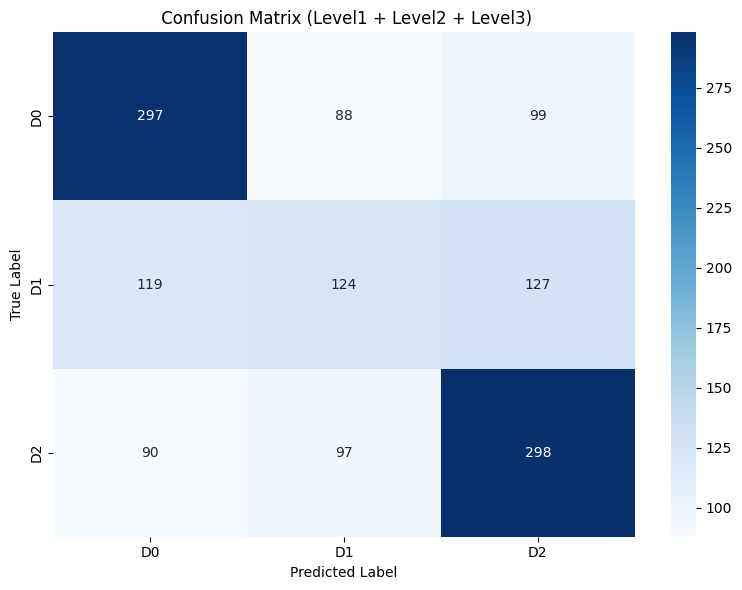

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CLASSIFICATION REPORT ---
print("\n Classification Report:")
target_names = list(test1_data.class_indices.keys())
print(classification_report(all_true, all_pred, target_names=target_names))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(' Confusion Matrix (Level1 + Level2 + Level3)')
plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step

Classification Report (Test1):
              precision    recall  f1-score   support

          D0       0.70      0.72      0.71        58
          D1       0.49      0.37      0.42        46
          D2       0.56      0.66      0.61        53

    accuracy                           0.60       157
   macro avg       0.58      0.58      0.58       157
weighted avg       0.59      0.60      0.59       157

Confusion Matrix (Test1):


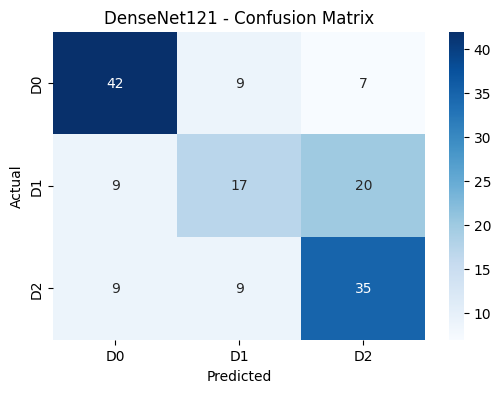

In [20]:
# Classification report and confusion matrix (on test1)
y_true = test1_data.classes
y_pred = np.argmax(model.predict(test1_data), axis=1)
class_labels = list(test1_data.class_indices.keys())

print("\nClassification Report (Test1):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test1):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step

Classification Report (Test1):
              precision    recall  f1-score   support

          D0       0.57      0.60      0.58       174
          D1       0.43      0.41      0.42       180
          D2       0.48      0.48      0.48       180

    accuracy                           0.49       534
   macro avg       0.49      0.49      0.49       534
weighted avg       0.49      0.49      0.49       534

Confusion Matrix (Test2):


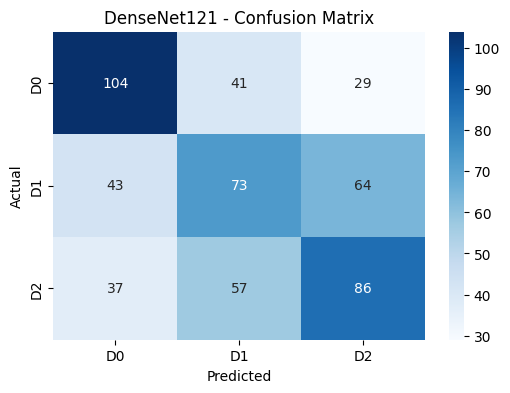

In [21]:
# Classification report and confusion matrix (on test1)
y_true = test2_data.classes
y_pred = np.argmax(model.predict(test2_data), axis=1)
class_labels = list(test2_data.class_indices.keys())

print("\nClassification Report (Test1):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test2):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 526ms/step

Classification Report (Test1):
              precision    recall  f1-score   support

          D0       0.58      0.60      0.59       252
          D1       0.33      0.24      0.28       144
          D2       0.63      0.70      0.66       252

    accuracy                           0.56       648
   macro avg       0.51      0.51      0.51       648
weighted avg       0.54      0.56      0.55       648

Confusion Matrix (Test3):


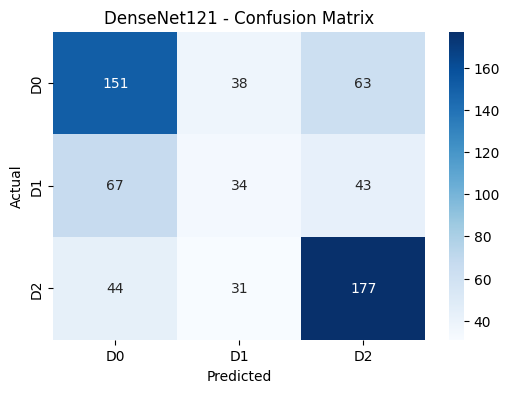

In [22]:
# Classification report and confusion matrix (on test1)
y_true = test3_data.classes
y_pred = np.argmax(model.predict(test3_data), axis=1)
class_labels = list(test3_data.class_indices.keys())

print("\nClassification Report (Test1):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test3):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

In [23]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- CONFIGURABLE PART ---
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '50'  # Change to '50' or '75' for other rounds

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_root = os.path.join(base_percent_path, 'Training')

training_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']
training_paths = [os.path.join(training_root, sub) for sub in training_subfolders]

# --- TEMP WORKING DIRECTORIES ---
r3_train_dir = f'round3_{percent_folder}/train'
r3_test1_dir = f'round3_{percent_folder}/test1'
r3_test2_dir = f'round3_{percent_folder}/test2'
r3_test3_dir = f'round3_{percent_folder}/test3'

for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# --- UTILITY FUNCTION ---
def split_and_copy(src_folder, dst_folder):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)

        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

# --- BUILD TRAINING DATA ---
for path in training_paths:
    split_and_copy(path, r3_train_dir)

# --- BUILD TEST SETS ---
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)

# --- IMAGE GENERATORS ---
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1555 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [24]:

# --- DENSENET MODEL ---
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=25, validation_data=test1_data)




Epoch 1/25


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 541ms/step - accuracy: 0.3667 - loss: 1.4055 - val_accuracy: 0.4777 - val_loss: 1.0834
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 49s 497ms/step - accuracy: 0.4155 - loss: 1.0819 - val_accuracy: 0.5096 - val_loss: 1.0471
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 464ms/step - accuracy: 0.4154 - loss: 1.0706 - val_accuracy: 0.4586 - val_loss: 1.0479
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.4494 - loss: 1.0513 - val_accuracy: 0.5541 - val_loss: 1.0223
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 436ms/step - accuracy: 0.4271 - loss: 1.0605 - val_accuracy: 0.5414 - val_loss: 1.0088
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - accuracy: 0.4745 - loss: 1.0395 - val_accuracy: 0.4331 - val_loss: 1.0317
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 472ms/step - accuracy: 0.4517 - loss: 1.0529 - val_accuracy: 0.5223 - val_loss: 1.0011
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.4796 - loss: 1.0460 - val_accuracy: 0.445

In [25]:
history = model.fit(train_data, epochs=10, validation_data=test1_data)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 769ms/step - accuracy: 0.5747 - loss: 0.9276 - val_accuracy: 0.5159 - val_loss: 0.9523
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 71s 728ms/step - accuracy: 0.5511 - loss: 0.9378 - val_accuracy: 0.5541 - val_loss: 0.9299
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 630ms/step - accuracy: 0.5376 - loss: 0.9692 - val_accuracy: 0.5732 - val_loss: 0.9173
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 636ms/step - accuracy: 0.5548 - loss: 0.9348 - val_accuracy: 0.5605 - val_loss: 0.8988
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 655ms/step - accuracy: 0.5765 - loss: 0.8828 - val_accuracy: 0.5732 - val_loss: 0.8794
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 646ms/step - accuracy: 0.5890 - loss: 0.8549 - val_accuracy: 0.5605 - val_loss: 0.9086
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 639ms/step - accuracy: 0.5449 - loss: 0.9043 - val_accuracy: 0.5541 - val_loss: 0.8984
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 638ms/step - accuracy: 0.5876 - loss: 0.8800 - val_accu

In [26]:
history = model.fit(train_data, epochs=20, validation_data=test1_data)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 749ms/step - accuracy: 0.5251 - loss: 0.9160 - val_accuracy: 0.5478 - val_loss: 0.8851
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 751ms/step - accuracy: 0.6129 - loss: 0.8428 - val_accuracy: 0.5414 - val_loss: 0.8914
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 71s 723ms/step - accuracy: 0.5711 - loss: 0.8552 - val_accuracy: 0.5541 - val_loss: 0.8993
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 729ms/step - accuracy: 0.5991 - loss: 0.8455 - val_accuracy: 0.5605 - val_loss: 0.9546
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 735ms/step - accuracy: 0.5745 - loss: 0.8760 - val_accuracy: 0.5669 - val_loss: 0.8963
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 762ms/step - accuracy: 0.6072 - loss: 0.8302 - val_accuracy: 0.5732 - val_loss: 0.9172
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 71s 726ms/step - accuracy: 0.6108 - loss: 0.8292 - val_accuracy: 0.5924 - val_loss: 0.9091
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 71s 723ms/step - accuracy: 0.5856 - loss: 0.8464 - val_accu

In [27]:
# --- EVALUATION ---
print(f"\n Test Level 1 ({percent_folder}%):")
model.evaluate(test1_data)

print("\n Test Level 2 (Inbox):")
model.evaluate(test2_data)

print("\nTest Level 3 (Outbox):")
model.evaluate(test3_data)


 Test Level 1 (50%):
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step - accuracy: 0.6377 - loss: 0.8426

 Test Level 2 (Inbox):
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 439ms/step - accuracy: 0.4792 - loss: 1.0233

Test Level 3 (Outbox):
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.6930 - loss: 0.7733


[0.8477531671524048, 0.6311728358268738]

In [29]:

# --- PRINT TRAINING & VALIDATION ACCURACY ---
print("\n--- Training & Validation Accuracy ---")
for epoch, (t_acc, v_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Training Accuracy = {t_acc:.4f}, Validation Accuracy = {v_acc:.4f}")

# --- EVALUATION ON TEST SETS ---
print(f"\n--- Test Accuracy Results for {percent_folder}% Round ---")
test1_loss, test1_acc = model.evaluate(test1_data, verbose=0)
print(f"Test Level 1 (10%Base): Accuracy = {test1_acc:.4f}")

test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test Level 2 (Inbox): Accuracy = {test2_acc:.4f}")

test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test Level 3 (Outbox): Accuracy = {test3_acc:.4f}")


--- Training & Validation Accuracy ---
Epoch 1: Training Accuracy = 0.5498, Validation Accuracy = 0.5478
Epoch 2: Training Accuracy = 0.6013, Validation Accuracy = 0.5414
Epoch 3: Training Accuracy = 0.5736, Validation Accuracy = 0.5541
Epoch 4: Training Accuracy = 0.5936, Validation Accuracy = 0.5605
Epoch 5: Training Accuracy = 0.5788, Validation Accuracy = 0.5669
Epoch 6: Training Accuracy = 0.6122, Validation Accuracy = 0.5732
Epoch 7: Training Accuracy = 0.6071, Validation Accuracy = 0.5924
Epoch 8: Training Accuracy = 0.5981, Validation Accuracy = 0.5669
Epoch 9: Training Accuracy = 0.6193, Validation Accuracy = 0.5350
Epoch 10: Training Accuracy = 0.6167, Validation Accuracy = 0.5478
Epoch 11: Training Accuracy = 0.6077, Validation Accuracy = 0.5541
Epoch 12: Training Accuracy = 0.6051, Validation Accuracy = 0.5478
Epoch 13: Training Accuracy = 0.6148, Validation Accuracy = 0.5669
Epoch 14: Training Accuracy = 0.6219, Validation Accuracy = 0.5541
Epoch 15: Training Accuracy = 0

In [28]:
# Evaluate accuracy
print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation (Test1) Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
# Evaluate on Test2 and Test3
test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test2 (Inbox) Accuracy: {test2_acc * 100:.2f}%")
test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test3 (Outbox) Accuracy: {test3_acc * 100:.2f}%")


Training Accuracy: 61.16%
Validation (Test1) Accuracy: 58.60%
Test2 (Inbox) Accuracy: 46.63%
Test3 (Outbox) Accuracy: 63.12%


In [30]:
from sklearn.metrics import accuracy_score
import numpy as np

def get_all_predictions(data_gen):
    predictions = model.predict(data_gen, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_gen.classes
    return true_classes, predicted_classes

# Get predictions for all test sets
true1, pred1 = get_all_predictions(test1_data)
true2, pred2 = get_all_predictions(test2_data)
true3, pred3 = get_all_predictions(test3_data)

# Combine all true and predicted labels
all_true = np.concatenate([true1, true2, true3])
all_pred = np.concatenate([pred1, pred2, pred3])

# Compute overall accuracy
overall_acc = accuracy_score(all_true, all_pred)
print(f"\n Overall Accuracy across all levels (Level1 + Level2 + Level3): {overall_acc:.4f}")



 Overall Accuracy across all levels (Level1 + Level2 + Level3): 0.5601



 Classification Report:
              precision    recall  f1-score   support

          D0       0.62      0.67      0.64       484
          D1       0.47      0.23      0.31       370
          D2       0.54      0.71      0.61       485

    accuracy                           0.56      1339
   macro avg       0.54      0.53      0.52      1339
weighted avg       0.55      0.56      0.54      1339



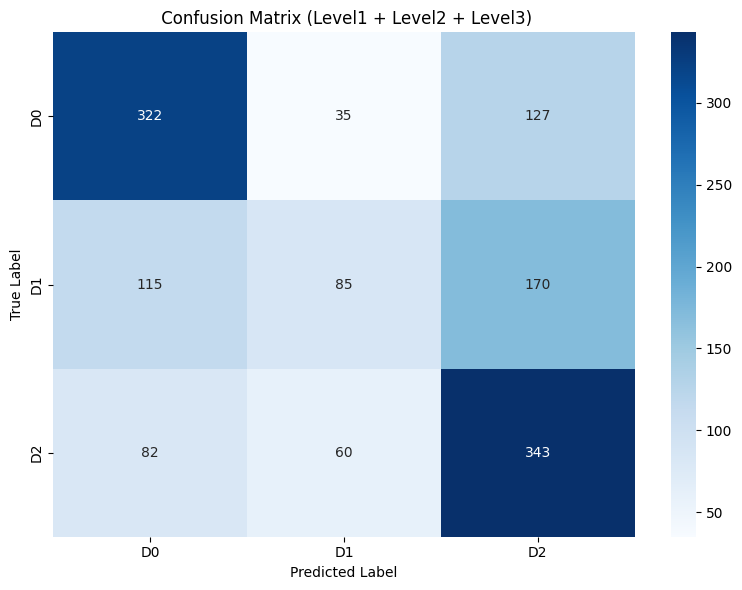

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CLASSIFICATION REPORT ---
print("\n Classification Report:")
target_names = list(test1_data.class_indices.keys())
print(classification_report(all_true, all_pred, target_names=target_names))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(' Confusion Matrix (Level1 + Level2 + Level3)')
plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step

Classification Report (Test1):
              precision    recall  f1-score   support

          D0       0.67      0.74      0.70        58
          D1       0.50      0.20      0.28        46
          D2       0.53      0.75      0.62        53

    accuracy                           0.59       157
   macro avg       0.57      0.56      0.54       157
weighted avg       0.57      0.59      0.55       157

Confusion Matrix (Test1):


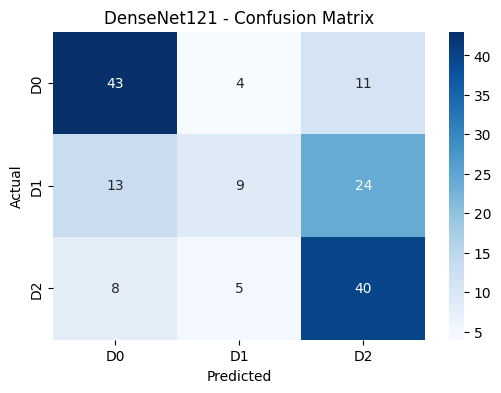

In [32]:
# Classification report and confusion matrix (on test1)
y_true = test1_data.classes
y_pred = np.argmax(model.predict(test1_data), axis=1)
class_labels = list(test1_data.class_indices.keys())

print("\nClassification Report (Test1):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test1):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step

Classification Report (Test2):
              precision    recall  f1-score   support

          D0       0.54      0.58      0.56       174
          D1       0.43      0.25      0.32       180
          D2       0.43      0.57      0.49       180

    accuracy                           0.47       534
   macro avg       0.46      0.47      0.45       534
weighted avg       0.46      0.47      0.45       534

Confusion Matrix (Test2):


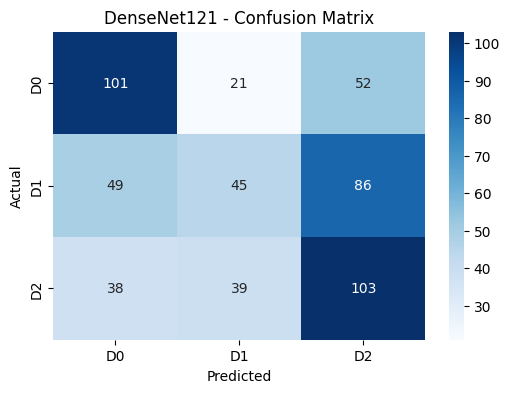

In [33]:
# Classification report and confusion matrix (on test1)
y_true = test2_data.classes
y_pred = np.argmax(model.predict(test2_data), axis=1)
class_labels = list(test1_data.class_indices.keys())

print("\nClassification Report (Test2):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test2):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 365ms/step

Classification Report (Test3):
              precision    recall  f1-score   support

          D0       0.67      0.71      0.69       252
          D1       0.54      0.22      0.31       144
          D2       0.62      0.79      0.69       252

    accuracy                           0.63       648
   macro avg       0.61      0.57      0.56       648
weighted avg       0.62      0.63      0.61       648

Confusion Matrix (Test3):


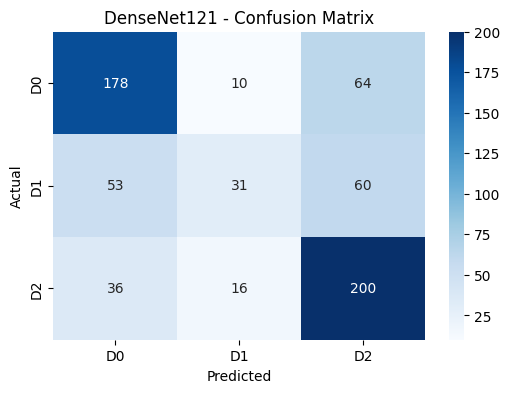

In [34]:
# Classification report and confusion matrix (on test1)
y_true = test3_data.classes
y_pred = np.argmax(model.predict(test3_data), axis=1)
class_labels = list(test3_data.class_indices.keys())

print("\nClassification Report (Test3):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test3):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- CONFIGURABLE PART ---
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '75'  # Change to '50' or '75' for other rounds

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_root = os.path.join(base_percent_path, 'Training')

training_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']
training_paths = [os.path.join(training_root, sub) for sub in training_subfolders]

# --- TEMP WORKING DIRECTORIES ---
r3_train_dir = f'round3_{percent_folder}/train'
r3_test1_dir = f'round3_{percent_folder}/test1'
r3_test2_dir = f'round3_{percent_folder}/test2'
r3_test3_dir = f'round3_{percent_folder}/test3'

for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# --- UTILITY FUNCTION ---
def split_and_copy(src_folder, dst_folder):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)

        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

# --- BUILD TRAINING DATA ---
for path in training_paths:
    split_and_copy(path, r3_train_dir)

# --- BUILD TEST SETS ---
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)

# --- IMAGE GENERATORS ---
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1497 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [2]:

# --- DENSENET MODEL ---
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=15, validation_data=test1_data)

Epoch 1/15


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 396ms/step - accuracy: 0.3298 - loss: 1.5538 - val_accuracy: 0.4522 - val_loss: 1.0516
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 428ms/step - accuracy: 0.3830 - loss: 1.1003 - val_accuracy: 0.4586 - val_loss: 1.0559
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 427ms/step - accuracy: 0.4245 - loss: 1.0769 - val_accuracy: 0.4841 - val_loss: 1.0480
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - accuracy: 0.4433 - loss: 1.0589 - val_accuracy: 0.5096 - val_loss: 1.0302
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 390ms/step - accuracy: 0.4110 - loss: 1.0736 - val_accuracy: 0.4777 - val_loss: 1.0484
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 402ms/step - accuracy: 0.4776 - loss: 1.0489 - val_accuracy: 0.5032 - val_loss: 1.0332
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 399ms/step - accuracy: 0.4384 - loss: 1.0567 - val_accuracy: 0.5096 - val_loss: 1.0128
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 402ms/step - accuracy: 0.4327 - loss: 1.0589 - val_accuracy: 0.433

In [3]:
# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=20, validation_data=test1_data)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - accuracy: 0.5140 - loss: 0.9789 - val_accuracy: 0.5605 - val_loss: 0.9280
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 383ms/step - accuracy: 0.5211 - loss: 0.9741 - val_accuracy: 0.5605 - val_loss: 0.9307
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.4890 - loss: 0.9861 - val_accuracy: 0.5669 - val_loss: 0.9433
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - accuracy: 0.5185 - loss: 0.9738 - val_accuracy: 0.5605 - val_loss: 0.9274
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.4926 - loss: 0.9892 - val_accuracy: 0.5669 - val_loss: 0.9446
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.5140 - loss: 0.9660 - val_accuracy: 0.6178 - val_loss: 0.9177
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.5190 - loss: 0.9454 - val_accuracy: 0.5796 - val_loss: 0.9229
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 400ms/step - accuracy: 0.5149 - loss: 0.9559 - val_accu

In [5]:
# --- TRAIN MODEL ---
history = model.fit(train_data, epochs=15, validation_data=test1_data)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.5457 - loss: 0.9088 - val_accuracy: 0.5414 - val_loss: 0.9227
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 395ms/step - accuracy: 0.5554 - loss: 0.9085 - val_accuracy: 0.5796 - val_loss: 0.9033
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.5442 - loss: 0.9028 - val_accuracy: 0.5605 - val_loss: 0.9274
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 395ms/step - accuracy: 0.5435 - loss: 0.9094 - val_accuracy: 0.5605 - val_loss: 0.8801
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.5423 - loss: 0.8963 - val_accuracy: 0.5796 - val_loss: 0.8819
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.5618 - loss: 0.8867 - val_accuracy: 0.5732 - val_loss: 0.8818
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 388ms/step - accuracy: 0.5542 - loss: 0.8747 - val_accuracy: 0.5796 - val_loss: 0.8957
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 390ms/step - accuracy: 0.5666 - loss: 0.8881 - val_accu

In [6]:
# --- EVALUATION ---
print(f"\n Test Level 1 ({percent_folder}%):")
model.evaluate(test1_data)

print("\n Test Level 2 (Inbox):")
model.evaluate(test2_data)

print("\nTest Level 3 (Outbox):")
model.evaluate(test3_data)


 Test Level 1 (75%):
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.5283 - loss: 1.0438

 Test Level 2 (Inbox):
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.3550 - loss: 1.2341

Test Level 3 (Outbox):
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - accuracy: 0.4987 - loss: 1.0302


[0.9254233241081238, 0.5617284178733826]

In [24]:

# --- PRINT TRAINING & VALIDATION ACCURACY ---
print("\n--- Training & Validation Accuracy ---")
for epoch, (t_acc, v_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {epoch}: Training Accuracy = {t_acc:.4f}, Validation Accuracy = {v_acc:.4f}")

# --- EVALUATION ON TEST SETS ---
print(f"\n--- Test Accuracy Results for {percent_folder}% Round ---")
test1_loss, test1_acc = model.evaluate(test1_data, verbose=0)
print(f"Test Level 1 (10%Base): Accuracy = {test1_acc:.4f}")

test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test Level 2 (Inbox): Accuracy = {test2_acc:.4f}")

test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test Level 3 (Outbox): Accuracy = {test3_acc:.4f}")


--- Training & Validation Accuracy ---
Epoch 1: Training Accuracy = 0.3814, Validation Accuracy = 0.4522
Epoch 2: Training Accuracy = 0.4055, Validation Accuracy = 0.3885
Epoch 3: Training Accuracy = 0.4115, Validation Accuracy = 0.4777
Epoch 4: Training Accuracy = 0.4302, Validation Accuracy = 0.5223
Epoch 5: Training Accuracy = 0.4335, Validation Accuracy = 0.4713
Epoch 6: Training Accuracy = 0.4456, Validation Accuracy = 0.5541
Epoch 7: Training Accuracy = 0.4522, Validation Accuracy = 0.5287
Epoch 8: Training Accuracy = 0.4649, Validation Accuracy = 0.5223
Epoch 9: Training Accuracy = 0.4863, Validation Accuracy = 0.5096
Epoch 10: Training Accuracy = 0.4783, Validation Accuracy = 0.5223
Epoch 11: Training Accuracy = 0.4963, Validation Accuracy = 0.4904
Epoch 12: Training Accuracy = 0.4930, Validation Accuracy = 0.5350
Epoch 13: Training Accuracy = 0.4997, Validation Accuracy = 0.5223
Epoch 14: Training Accuracy = 0.5190, Validation Accuracy = 0.5669
Epoch 15: Training Accuracy = 0

In [7]:
# Evaluate accuracy
print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation (Test1) Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
# Evaluate on Test2 and Test3
test2_loss, test2_acc = model.evaluate(test2_data, verbose=0)
print(f"Test2 (Inbox) Accuracy: {test2_acc * 100:.2f}%")
test3_loss, test3_acc = model.evaluate(test3_data, verbose=0)
print(f"Test3 (Outbox) Accuracy: {test3_acc * 100:.2f}%")


Training Accuracy: 57.25%
Validation (Test1) Accuracy: 52.87%
Test2 (Inbox) Accuracy: 45.88%
Test3 (Outbox) Accuracy: 56.17%


In [25]:
from sklearn.metrics import accuracy_score
import numpy as np

def get_all_predictions(data_gen):
    predictions = model.predict(data_gen, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_gen.classes
    return true_classes, predicted_classes

# Get predictions for all test sets
true1, pred1 = get_all_predictions(test1_data)
true2, pred2 = get_all_predictions(test2_data)
true3, pred3 = get_all_predictions(test3_data)

# Combine all true and predicted labels
all_true = np.concatenate([true1, true2, true3])
all_pred = np.concatenate([pred1, pred2, pred3])

# Compute overall accuracy
overall_acc = accuracy_score(all_true, all_pred)
print(f"\n Overall Accuracy across all levels (Level1 + Level2 + Level3): {overall_acc:.4f}")



 Overall Accuracy across all levels (Level1 + Level2 + Level3): 0.5183


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 745ms/step

Classification Report (Test1):
              precision    recall  f1-score   support

          D0       0.76      0.53      0.63        58
          D1       0.47      0.20      0.28        46
          D2       0.44      0.81      0.57        53

    accuracy                           0.53       157
   macro avg       0.56      0.51      0.49       157
weighted avg       0.57      0.53      0.51       157

Confusion Matrix (Test1):


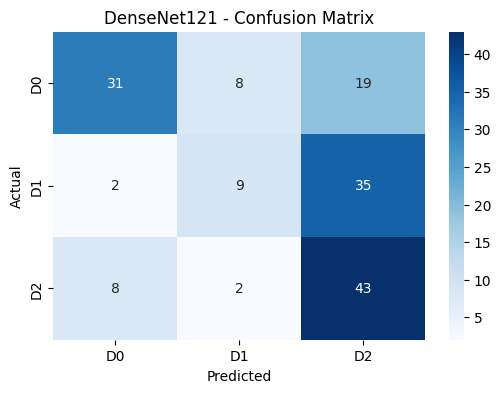

In [9]:
# Classification report and confusion matrix (on test1)
y_true = test1_data.classes
y_pred = np.argmax(model.predict(test1_data), axis=1)
class_labels = list(test1_data.class_indices.keys())

print("\nClassification Report (Test1):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test1):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step

Classification Report (Test2):
              precision    recall  f1-score   support

          D0       0.68      0.39      0.50       174
          D1       0.41      0.19      0.26       180
          D2       0.41      0.79      0.54       180

    accuracy                           0.46       534
   macro avg       0.50      0.46      0.43       534
weighted avg       0.50      0.46      0.43       534

Confusion Matrix (Test2):


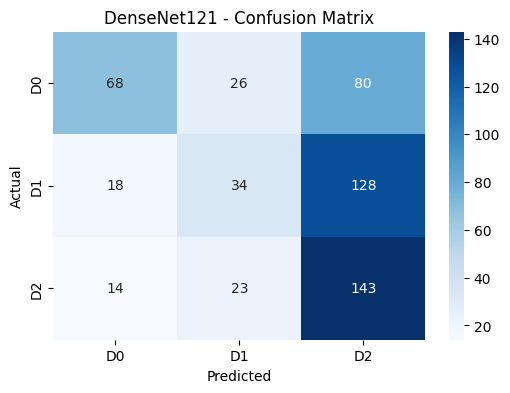

In [10]:
# Classification report and confusion matrix (on test2)
y_true = test2_data.classes
y_pred = np.argmax(model.predict(test2_data), axis=1)
class_labels = list(test2_data.class_indices.keys())

print("\nClassification Report (Test2):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test2):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

In [1]:
# Classification report and confusion matrix (on test3)
y_true = test3_data.classes
y_pred = np.argmax(model.predict(test3_data), axis=1)
class_labels = list(test3_data.class_indices.keys())

print("\nClassification Report (Test3):")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix (Test3):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet121 - Confusion Matrix')
plt.show()

NameError: name 'test3_data' is not defined